## Metodologia 1

Essa metodologia segue a seguinte definição:

- Definir um script para setar pontos por iteração, para que, a cada novo ponto adicionado, seja melhorado o resultado da segmentação. Foi notado em experimentos manuais usando ViT-H que, ao colocar um ponto positivo na região central da fácies que se deseja segmentar, o modelo consegue capturar boa parte da região alvo, porém acaba "vazando" para regiões vizinhas. Assim, o algoritmo abaixo define o processo da adição dos pontos:

### Algoritmo 1
1. Escolha uma fácie para ser segmentada.
2. Defina a quantidade de pontos que serão usados.
3. Calcule o ponto médio dessa região e adicione um ponto na região que represente o meio.
4. Calcule a diferença entre a área da fácie real com a predita pelo modelo.
5. Se a diferença sobrar região para a predição, então o próximo ponto deverá ser negativo. Caso contrário, ou seja, se a diferença sobrar para a área real, então o próximo ponto deverá ser positivo.
6. Volte para o passo 3 e subtraia o total de pontos possíveis.
7. Para cada passo, salve o iou de cada ponto e o iou acumulado.
8. Calcule a área sob a curva (AOC) da segmentação usando os valores de IoU acumulado por iteração.

9. (ADICIONAL) adicionar prompt de caixa e checar usando AOC se colocar prompt de caixa melhora ou não as segmentações.

- OBS:
1. Para cada algoritmo:
    - Salvar visualmente as predições intermediárias (máscaras) em cada iteração pode ajudar a entender como os pontos positivos/negativos impactam a segmentação.
    - Plotar as curvas de IoU acumulado ao longo das iterações.
2. Tomar cuidado no calculo da diferença:
    - Ao executar, verá que há 2 áreas, uma para fora do ground truth e outra para dentro. Deve ser selecionado a área maior, e a partir dela, definir o ponto na região do meio.

Após isso, fazer a seleção de X amostras e requisitar pessoas para realizar a segmentação das fácies da seguinte forma:
- Dado uma seção, segmente as F fácies as segas usando N pontos.
- Dado uma seção e sua label, olhe uma vez a label e segmente as F fácies com os mesmos N pontos.

## Imports

In [1]:
import os
from pathlib import Path
from typing import Optional
import numpy as np
from typing import List, Optional, Tuple
from copy import deepcopy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import auc

import torch
from torch.nn import functional as F
from torchvision.transforms.functional import resize, to_pil_image

from minerva.models.nets.image.sam import Sam
from minerva.data.readers.png_reader import PNGReader
from minerva.data.readers.tiff_reader import TiffReader

import cv2

from torchmetrics import JaccardIndex

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print("CUDA Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA Device")

PyTorch Version: 2.5.1+cu124
CUDA Version: 12.4
CUDA Available: True
CUDA Device Count: 1
CUDA Device Name: NVIDIA GeForce RTX 4090


## Variables

In [3]:
# f3
# train_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/images"
# annotation_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/annotations"

# parihaka
train_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/images"
annotation_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/annotations"

# checkpoints SAM
checkpoint_path = "/workspaces/Minerva-Discovery/shared_data/weights_sam/checkpoints_sam/sam_vit_b_01ec64.pth" # vit_b
# checkpoint_path = "/workspaces/Minerva-Discovery/shared_data/weights_sam/checkpoints_sam/sam_vit_h_4b8939.pth" # vit_h

model_name = "SAM-ViT_B"
vit_model = 'vit-b'
# vit_model = 'vit-h'
multimask_output=False
num_classes = 3
# apply_freeze={"prompt_encoder": False, "image_encoder": False, "mask_decoder": False}
# apply_adapter={}#{"image_encoder": LoRALinear, "mask_decoder": LoRALinear}

## Transform

In [4]:
class ResizeLongestSide:
    """
    Resizes images to the longest side 'target_length', as well as provides
    methods for resizing coordinates and boxes. Provides methods for
    transforming both numpy array and batched torch tensors.
    """

    def __init__(self, target_length: int) -> None:
        self.target_length = target_length

    def apply_image(self, image: np.ndarray) -> np.ndarray:
        """
        Expects a numpy array with shape HxWxC in uint8 format.
        """
        target_size = self.get_preprocess_shape(image.shape[0], image.shape[1], self.target_length)
        return np.array(resize(to_pil_image(image), target_size))

    def apply_coords(self, coords: np.ndarray, original_size: Tuple[int, ...]) -> np.ndarray:
        """
        Expects a numpy array of length 2 in the final dimension. Requires the
        original image size in (H, W) format.
        """
        old_h, old_w = original_size
        new_h, new_w = self.get_preprocess_shape(
            original_size[0], original_size[1], self.target_length
        )
        coords = deepcopy(coords).astype(float)
        coords[..., 0] = coords[..., 0] * (new_w / old_w)
        coords[..., 1] = coords[..., 1] * (new_h / old_h)
        return coords

    def apply_boxes(self, boxes: np.ndarray, original_size: Tuple[int, ...]) -> np.ndarray:
        """
        Expects a numpy array shape Bx4. Requires the original image size
        in (H, W) format.
        """
        boxes = self.apply_coords(boxes.reshape(-1, 2, 2), original_size)
        return boxes.reshape(-1, 4)

    def apply_image_torch(self, image: torch.Tensor) -> torch.Tensor:
        """
        Expects batched images with shape BxCxHxW and float format. This
        transformation may not exactly match apply_image. apply_image is
        the transformation expected by the model.
        """
        # Expects an image in BCHW format. May not exactly match apply_image.
        target_size = self.get_preprocess_shape(image.shape[2], image.shape[3], self.target_length)
        return F.interpolate(
            image, target_size, mode="bilinear", align_corners=False, antialias=True
        )

    def apply_coords_torch(
        self, coords: torch.Tensor, original_size: Tuple[int, ...]
    ) -> torch.Tensor:
        """
        Expects a torch tensor with length 2 in the last dimension. Requires the
        original image size in (H, W) format.
        """
        old_h, old_w = original_size
        new_h, new_w = self.get_preprocess_shape(
            original_size[0], original_size[1], self.target_length
        )
        coords = deepcopy(coords).to(torch.float)
        coords[..., 0] = coords[..., 0] * (new_w / old_w)
        coords[..., 1] = coords[..., 1] * (new_h / old_h)
        return coords

    def apply_boxes_torch(
        self, boxes: torch.Tensor, original_size: Tuple[int, ...]
    ) -> torch.Tensor:
        """
        Expects a torch tensor with shape Bx4. Requires the original image
        size in (H, W) format.
        """
        boxes = self.apply_coords_torch(boxes.reshape(-1, 2, 2), original_size)
        return boxes.reshape(-1, 4)

    @staticmethod
    def get_preprocess_shape(oldh: int, oldw: int, long_side_length: int) -> Tuple[int, int]:
        """
        Compute the output size given input size and target long side length.
        """
        scale = long_side_length * 1.0 / max(oldh, oldw)
        newh, neww = oldh * scale, oldw * scale
        neww = int(neww + 0.5)
        newh = int(newh + 0.5)
        return (newh, neww)

## Predict Class

In [5]:
class SamPredictor:
    def __init__(
        self,
        sam_model: Sam,
    ) -> None:
        """
        Uses SAM to calculate the image embedding for an image, and then
        allow repeated, efficient mask prediction given prompts.

        Arguments:
          sam_model (Sam): The model to use for mask prediction.
        """
        super().__init__()
        self.model = sam_model.model
        self.device = sam_model.device
        self.transform = ResizeLongestSide(self.model.image_encoder.img_size)
        self.reset_image()

    def set_image(
        self,
        image: np.ndarray,
        image_format: str = "RGB",
    ) -> None:
        """
        Calculates the image embeddings for the provided image, allowing
        masks to be predicted with the 'predict' method.

        Arguments:
          image (np.ndarray): The image for calculating masks. Expects an
            image in HWC uint8 format, with pixel values in [0, 255].
          image_format (str): The color format of the image, in ['RGB', 'BGR'].
        """
        assert image_format in [
            "RGB",
            "BGR",
        ], f"image_format must be in ['RGB', 'BGR'], is {image_format}."
        # if image_format != self.model.image_format:
        #     image = image[..., ::-1]

        # Transform the image to the form expected by the model
        input_image = self.transform.apply_image(image)
        input_image_torch = torch.as_tensor(input_image, device=self.device)
        input_image_torch = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

        self.set_torch_image(input_image_torch, image.shape[:2])

    @torch.no_grad()
    def set_torch_image(
        self,
        transformed_image: torch.Tensor,
        original_image_size: Tuple[int, ...],
    ) -> None:
        """
        Calculates the image embeddings for the provided image, allowing
        masks to be predicted with the 'predict' method. Expects the input
        image to be already transformed to the format expected by the model.

        Arguments:
          transformed_image (torch.Tensor): The input image, with shape
            1x3xHxW, which has been transformed with ResizeLongestSide.
          original_image_size (tuple(int, int)): The size of the image
            before transformation, in (H, W) format.
        """
        assert (
            len(transformed_image.shape) == 4
            and transformed_image.shape[1] == 3
            and max(*transformed_image.shape[2:]) == self.model.image_encoder.img_size
        ), f"set_torch_image input must be BCHW with long side {self.model.image_encoder.img_size}."
        self.reset_image()

        self.original_size = original_image_size
        self.input_size = tuple(transformed_image.shape[-2:])
        input_image = self.model.preprocess(transformed_image)
        self.features = self.model.image_encoder(input_image)
        self.is_image_set = True

    def predict(
        self,
        point_coords: Optional[np.ndarray] = None,
        point_labels: Optional[np.ndarray] = None,
        box: Optional[np.ndarray] = None,
        mask_input: Optional[np.ndarray] = None,
        multimask_output: bool = True,
        return_logits: bool = False,
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Predict masks for the given input prompts, using the currently set image.

        Arguments:
          point_coords (np.ndarray or None): A Nx2 array of point prompts to the
            model. Each point is in (X,Y) in pixels.
          point_labels (np.ndarray or None): A length N array of labels for the
            point prompts. 1 indicates a foreground point and 0 indicates a
            background point.
          box (np.ndarray or None): A length 4 array given a box prompt to the
            model, in XYXY format.
          mask_input (np.ndarray): A low resolution mask input to the model, typically
            coming from a previous prediction iteration. Has form 1xHxW, where
            for SAM, H=W=256.
          multimask_output (bool): If true, the model will return three masks.
            For ambiguous input prompts (such as a single click), this will often
            produce better masks than a single prediction. If only a single
            mask is needed, the model's predicted quality score can be used
            to select the best mask. For non-ambiguous prompts, such as multiple
            input prompts, multimask_output=False can give better results.
          return_logits (bool): If true, returns un-thresholded masks logits
            instead of a binary mask.

        Returns:
          (np.ndarray): The output masks in CxHxW format, where C is the
            number of masks, and (H, W) is the original image size.
          (np.ndarray): An array of length C containing the model's
            predictions for the quality of each mask.
          (np.ndarray): An array of shape CxHxW, where C is the number
            of masks and H=W=256. These low resolution logits can be passed to
            a subsequent iteration as mask input.
        """
        if not self.is_image_set:
            raise RuntimeError("An image must be set with .set_image(...) before mask prediction.")

        # Transform input prompts
        coords_torch, labels_torch, box_torch, mask_input_torch = None, None, None, None
        if point_coords is not None:
            assert (
                point_labels is not None
            ), "point_labels must be supplied if point_coords is supplied."
            point_coords = self.transform.apply_coords(point_coords, self.original_size)
            coords_torch = torch.as_tensor(point_coords, dtype=torch.float, device=self.device)
            labels_torch = torch.as_tensor(point_labels, dtype=torch.int, device=self.device)
            coords_torch, labels_torch = coords_torch[None, :, :], labels_torch[None, :]
        if box is not None:
            box = self.transform.apply_boxes(box, self.original_size)
            box_torch = torch.as_tensor(box, dtype=torch.float, device=self.device)
            box_torch = box_torch[None, :]
        if mask_input is not None:
            mask_input_torch = torch.as_tensor(mask_input, dtype=torch.float, device=self.device)
            mask_input_torch = mask_input_torch[None, :, :, :]

        masks, iou_predictions, low_res_masks = self.predict_torch(
            coords_torch,
            labels_torch,
            box_torch,
            mask_input_torch,
            multimask_output,
            return_logits=return_logits,
        )

        masks_np = masks[0].detach().cpu().numpy()
        iou_predictions_np = iou_predictions[0].detach().cpu().numpy()
        low_res_masks_np = low_res_masks[0].detach().cpu().numpy()
        return masks_np, iou_predictions_np, low_res_masks_np

    @torch.no_grad()
    def predict_torch(
        self,
        point_coords: Optional[torch.Tensor],
        point_labels: Optional[torch.Tensor],
        boxes: Optional[torch.Tensor] = None,
        mask_input: Optional[torch.Tensor] = None,
        multimask_output: bool = True,
        return_logits: bool = False,
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Predict masks for the given input prompts, using the currently set image.
        Input prompts are batched torch tensors and are expected to already be
        transformed to the input frame using ResizeLongestSide.

        Arguments:
          point_coords (torch.Tensor or None): A BxNx2 array of point prompts to the
            model. Each point is in (X,Y) in pixels.
          point_labels (torch.Tensor or None): A BxN array of labels for the
            point prompts. 1 indicates a foreground point and 0 indicates a
            background point.
          boxes (np.ndarray or None): A Bx4 array given a box prompt to the
            model, in XYXY format.
          mask_input (np.ndarray): A low resolution mask input to the model, typically
            coming from a previous prediction iteration. Has form Bx1xHxW, where
            for SAM, H=W=256. Masks returned by a previous iteration of the
            predict method do not need further transformation.
          multimask_output (bool): If true, the model will return three masks.
            For ambiguous input prompts (such as a single click), this will often
            produce better masks than a single prediction. If only a single
            mask is needed, the model's predicted quality score can be used
            to select the best mask. For non-ambiguous prompts, such as multiple
            input prompts, multimask_output=False can give better results.
          return_logits (bool): If true, returns un-thresholded masks logits
            instead of a binary mask.

        Returns:
          (torch.Tensor): The output masks in BxCxHxW format, where C is the
            number of masks, and (H, W) is the original image size.
          (torch.Tensor): An array of shape BxC containing the model's
            predictions for the quality of each mask.
          (torch.Tensor): An array of shape BxCxHxW, where C is the number
            of masks and H=W=256. These low res logits can be passed to
            a subsequent iteration as mask input.
        """
        if not self.is_image_set:
            raise RuntimeError("An image must be set with .set_image(...) before mask prediction.")

        if point_coords is not None:
            points = (point_coords, point_labels)
        else:
            points = None

        # Embed prompts
        sparse_embeddings, dense_embeddings = self.model.prompt_encoder(
            points=points,
            boxes=boxes,
            masks=mask_input,
        )

        # Predict masks
        low_res_masks, iou_predictions = self.model.mask_decoder(
            image_embeddings=self.features,
            image_pe=self.model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=multimask_output,
        )

        # Upscale the masks to the original image resolution
        masks = self.model.postprocess_masks(low_res_masks, self.input_size, self.original_size)

        if not return_logits:
            masks = masks > self.model.mask_threshold

        return masks, iou_predictions, low_res_masks

    def reset_image(self) -> None:
        """Resets the currently set image."""
        self.is_image_set = False
        self.features = None
        self.orig_h = None
        self.orig_w = None
        self.input_h = None
        self.input_w = None

## Plots

In [6]:
def plot_all(image, label, pred, diff, score, point_coords, point_labels):
    """
    Plota as imagens lado a lado: imagem original, label, predição, diff.
    Pontos acumulados são exibidos sobre as imagens.
    """
    num_subplots = 4  # Número de subplots: imagem original, label, pred, diff
    plt.clf()
    fig, axes = plt.subplots(1, num_subplots, figsize=(5 * num_subplots, 5))

    # Plot 1: Imagem original
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Plot 2: Label
    axes[1].imshow(label, cmap='gray')
    axes[1].set_title("Label")
    axes[1].axis('off')

    # Plot 3: Predição acumulada
    axes[2].imshow(pred, cmap='gray')
    axes[2].set_title(f"Pred - Score: {score}")
    axes[2].axis('off')

    # Plot 4: Diferença entre label e pred
    axes[3].imshow(diff, cmap='gray')
    axes[3].set_title("Difference (Label - Pred)")
    axes[3].axis('off')

    # Adiciona os pontos em todas as imagens
    for ax in axes:
        for (x, y), label in zip(point_coords, point_labels):
            color = 'green' if label == 1 else 'red'
            ax.scatter(x, y, color=color, s=50, edgecolors='white')

    plt.tight_layout()
    plt.show()

## Algoritm

In [7]:
class Methodology_1():
    def __init__(self, 
                 predictor:SamPredictor,
                 train_path:str, 
                 annotation_path:str, 
                 data_type:str='test',
                 num_points:int=3 
                 ):
        self.predictor = predictor

        self.train_img_reader = TiffReader(Path(train_path) / data_type)
        self.train_label_reader = PNGReader(Path(annotation_path) / data_type)

        self.num_points = num_points

        self.set_points() # reseta pontos

        self.miou_metric = JaccardIndex(task="multiclass", num_classes=2).to(self.predictor.device) # binario
    
    def set_points(self):
        # Inicialize os acumuladores como arrays vazios
        self.accumulated_coords = np.empty((0, 2), dtype=int)  # Nx2 array
        self.accumulated_labels = np.empty((0,), dtype=int)   # Array de comprimento N
    
    def process(self):
        self.results = pd.DataFrame(columns=['sample_id', 'facie_id', 'accumulated_point', 'iou', 'num_points'])

        for idx, (image, label) in enumerate(zip(self.train_img_reader, self.train_label_reader)):
            num_facies = np.unique(label) # num de facies da amostra
            point_type = 'positive' # inicia com ponto positivo, depois pode mudar para 'negative'

            # convertendo para PNG (TODO refatorar isso)
            if image.dtype != np.uint8:
                tiff_image = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)
            else:
                tiff_image = image
            _, png_img = cv2.imencode('.png', tiff_image)
            decoded_image = cv2.imdecode(np.frombuffer(png_img, np.uint8), cv2.IMREAD_UNCHANGED)
            self.predictor.set_image(decoded_image) # seta a imagem para predição

            for i, facie in enumerate(num_facies):
                # print("Cor da facie: ", facie)
                region = np.zeros_like(label, dtype=np.uint8) # [H,W]
                region[label == facie] = 1
                real_label = region
                for point in range(self.num_points):
                    # plt.figure(figsize=(6, 6))  # Define o tamanho da figura
                    # plt.imshow(region)  # Mostra a imagem, com escala de cinza (ou RGB se for colorida)
                    # plt.title("o sabugo")  # Adiciona o título
                    # plt.axis('off')  # Desliga os eixos para uma visualização limpa
                    # plt.show()
                    
                    point_coords, point_labels = self.calculate_center_region(region=region, point_type=point_type)
                    # print(point_coords, point_labels)
                    masks, scores, logits = self.predictor.predict(
                        point_coords=point_coords,
                        point_labels=point_labels,
                        multimask_output=multimask_output, # controla ambiguidade
                    )
                    # calcular IoU
                    gt_tensor = torch.tensor(real_label).to(self.predictor.device)  # Converta para tensor 2D e mova para GPU
                    pred_tensor = torch.tensor(masks.squeeze()).to(self.predictor.device)  # Remover a dimensão extra e mover para GPU
                    iou_score = self.miou_metric(pred_tensor, gt_tensor)

                    diff, new_point_type = self.calculate_diff_label_pred(label=real_label, pred=masks.squeeze(0))
                    
                    # salvando progresso
                    new_row = pd.DataFrame([{
                        'sample_id': idx,
                        'facie_id': facie,
                        'accumulated_point': point + 1,
                        'iou': iou_score.item(),
                        'num_points': self.num_points
                    }])

                    self.results = pd.concat([self.results, new_row], ignore_index=True)
                    
                    # plot experimental a cada 50 amostras
                    # if idx % 50 == 0:
                    #     plot_all(
                    #         image=image,
                    #         label=real_label,
                    #         pred=masks.squeeze(0),  # empilha as máscaras geradas
                    #         diff=diff,
                    #         score=iou_score,
                    #         point_coords=self.accumulated_coords,
                    #         point_labels=self.accumulated_labels
                    #     )
                    region = diff # [H,W], atualiza para a proxima regiao
                    point_type = new_point_type # 'positive' ou 'negative', atualiza para a proxima regiao
                # break
                point_type = 'positive' # reinicia tipo do primeiro ponto (sempre deve ser positivo o primeiro)
                self.set_points() # reinicia empilhamento de pontos
            self.predictor.reset_image()
            # break # testar só uma amostra
        self.results.to_csv('iou_results.csv', index=False)

    def calculate_center_region(self, region: np.array, point_type: str, min_distance: int = 10):
        """
        Calcula o centroide da maior região de pixels brancos de uma imagem binária,
        deslocando horizontalmente o ponto se ele estiver próximo demais dos acumulados.

        Args:
            region (np.array): Imagem binária com a região de interesse (pixels brancos).
            point_type (str): Tipo do ponto ('positive' ou 'negative').
            min_distance (int): Distância mínima permitida entre pontos.

        Returns:
            point_coords (np.ndarray): Array Nx2 de pontos acumulados.
            point_labels (np.ndarray): Array N de rótulos acumulados.
        """
        if not isinstance(region, np.ndarray):
            raise TypeError("region needs to be a NumPy array.")
        
        # Encontrar as componentes conectadas
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(region, connectivity=8)

        if num_labels < 2:  # Apenas fundo e nenhuma região branca
            raise ValueError("No connected white regions found in the binary image.")
        
        # Ignorar o rótulo 0 (fundo), pegar a maior componente conectada
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        center_x, center_y = centroids[largest_label]
        center_x, center_y = int(center_x), int(center_y)
        new_coords = np.array([[center_x, center_y]])

        # Verificar se o ponto está muito próximo dos anteriores
        if self.accumulated_coords.shape[0] > 0:
            distances = np.sqrt(np.sum((self.accumulated_coords - new_coords) ** 2, axis=1))
            if np.any(distances < min_distance):
                # print("Ponto muito próximo ao anterior, deslocando horizontalmente...")
                
                # Tentar deslocar o ponto horizontalmente dentro da região branca
                region_height, region_width = region.shape
                # Tenta deslocar horizontalmente usando o min_distance
                for delta_x in range(min_distance, region_width, min_distance):  # Incrementa em min_distance
                    candidate_x_right = center_x + delta_x
                    candidate_x_left = center_x - delta_x

                    # Verifica primeiro para direita, depois para esquerda
                    if candidate_x_right < region_width and region[center_y, candidate_x_right] > 0:
                        center_x = candidate_x_right
                        break
                    elif candidate_x_left >= 0 and region[center_y, candidate_x_left] > 0:
                        center_x = candidate_x_left
                        break

                new_coords = np.array([[center_x, center_y]])

        # Definir o rótulo (positivo ou negativo)
        if point_type == 'positive':
            new_labels = np.array([1])
        elif point_type == 'negative':
            new_labels = np.array([0])
        else:
            raise ValueError("Invalid point_type. Must be 'positive' or 'negative'.")

        # Acumular os resultados
        self.accumulated_coords = np.vstack([self.accumulated_coords, new_coords])
        self.accumulated_labels = np.hstack([self.accumulated_labels, new_labels])

        return self.accumulated_coords, self.accumulated_labels
    
    def calculate_diff_label_pred(self, label:np.array, pred:np.array):
        """
        Calcula a diferença entre duas imagens binárias e determina se a área externa ou interna é maior.

        Args:
            label (np.array): Imagem binária de referência (label).
            pred (np.array): Imagem binária predita (pred).

        Returns:
            diff_colored (np.array): Imagem colorida representando as diferenças.
            point_type (str): 'negative' se a área externa for maior, 'positive' se a interna for maior.
        """
        if label.shape != pred.shape:
            raise ValueError("Label and Pred images have differents shapes. Check it before call calculate_dif_label_pred() function.")

        # Máscaras para regiões de diferença
        mask_outward = (label > pred)  # Diferença para fora -> Vermelho
        mask_inward = (label < pred)  # Diferença para dentro -> Azul

        area_outward = np.sum(mask_outward)
        area_inward = np.sum(mask_inward)

        diff_binary = teste1 = teste2 = np.zeros(label.shape, dtype=np.uint8) # [H,W]

        # fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        # teste1[mask_outward] = 1
        # axes[0].imshow(teste1)
        # axes[0].set_title('Image 1')
        # axes[0].axis('off')
        # teste2[mask_inward] = 1
        # axes[1].imshow(teste2)
        # axes[1].set_title('Image 2')
        # axes[1].axis('off')
        # plt.tight_layout()
        # plt.show()

        # Comparar as áreas
        if area_outward > area_inward:
            diff_binary[mask_outward] = 1
            point_type = 'positive'
        else:
            diff_binary[mask_inward] = 1
            point_type = 'negative'
        
        return diff_binary, point_type

## Execute algoritm 1

In [8]:
# defining device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print("Using device: ", device)

# init model (with device)
model = Sam(
    vit_type=vit_model,
    checkpoint=checkpoint_path,
    num_multimask_outputs=num_classes, # default: 3
    iou_head_depth=num_classes, # default: 3
    # apply_freeze=apply_freeze,
    # apply_adapter=apply_adapter
).to(device)

# print(model)

# init predictor
predictor = SamPredictor(sam_model=model)

# call algorithm class
algorithm = Methodology_1(
    predictor=predictor, 
    train_path=train_path, 
    annotation_path=annotation_path,
    data_type='test',
    num_points=10)

algorithm.process()

Using device:  cuda


/home/vscode/.local/lib/python3.10/site-packages/minerva/models/nets/image/sam.py:2339: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Prompt Encoder freeze!


/tmp/ipykernel_1746976/1334234376.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results = pd.concat([self.results, new_row], ignore_index=True)


## AUC

       sample_id  facie_id  accumulated_point       iou  num_points
0              0         0                  1  0.037065          10
1              0         0                  2  0.070886          10
2              0         0                  3  0.068481          10
3              0         0                  4  0.116163          10
4              0         0                  5  0.085572          10
...          ...       ...                ...       ...         ...
22745        399         4                  6  0.125467          10
22746        399         4                  7  0.102875          10
22747        399         4                  8  0.094097          10
22748        399         4                  9  0.079296          10
22749        399         4                 10  0.110524          10

[22750 rows x 5 columns]
Média de IoU por Facie e Ponto:
    facie_id  accumulated_point       iou
0          0                  1  0.078373
1          0                  2  0.075783


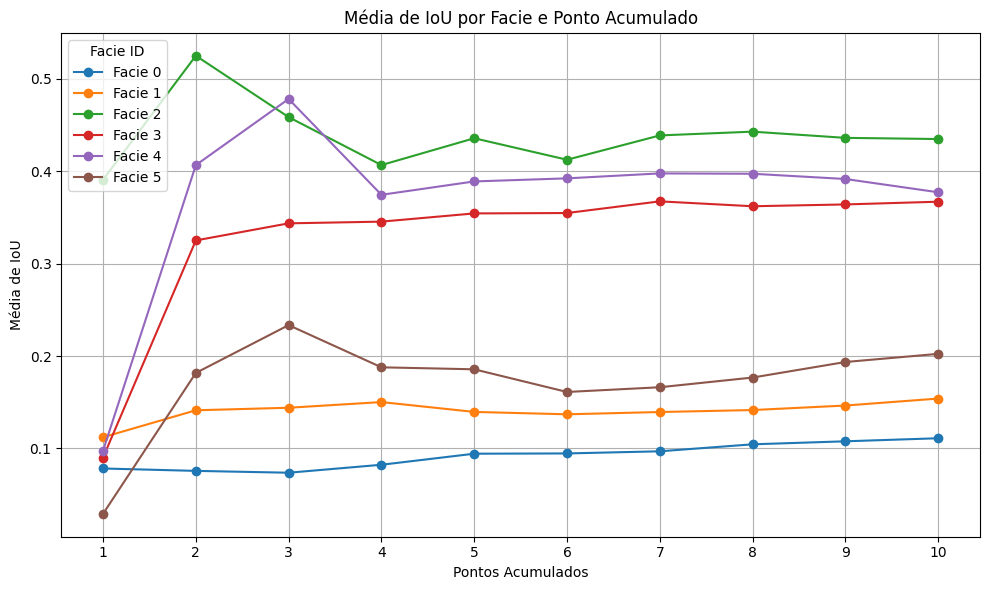

In [3]:
filename = 'SAM-ViT_B_fine_tuning_&_adapter_f3_iou_results.csv'
# media de iou por facie e ponto

results = pd.read_csv(filename)
print(results)

# Calcular a média de IoU para cada facie_id por ponto acumulado
mean_iou_per_facie = results.groupby(['facie_id', 'accumulated_point'])['iou'].mean().reset_index()

# Mostrar a média calculada
print("Média de IoU por Facie e Ponto:")
print(mean_iou_per_facie)


plt.figure(figsize=(10, 6))
# Iterar pelas facies e plotar a média de IoU
for facie_id in mean_iou_per_facie['facie_id'].unique():
    data = mean_iou_per_facie[mean_iou_per_facie['facie_id'] == facie_id]
    plt.plot(data['accumulated_point'], data['iou'], marker='o', label=f"Facie {facie_id}")
plt.title("Média de IoU por Facie e Ponto Acumulado")
plt.xlabel("Pontos Acumulados")
plt.ylabel("Média de IoU")
plt.xticks(mean_iou_per_facie['accumulated_point'].unique())  # Mostrar apenas os pontos exatos
plt.legend(title="Facie ID")
plt.tight_layout()
plt.grid(True)
plt.show()

Facie 0: AUC = 0.8249154245899986
Facie 1: AUC = 1.2725305464351546
Facie 2: AUC = 3.9668204376101492
Facie 3: AUC = 3.044108589615207
Facie 4: AUC = 3.462756981986553
Facie 5: AUC = 1.601869774169916


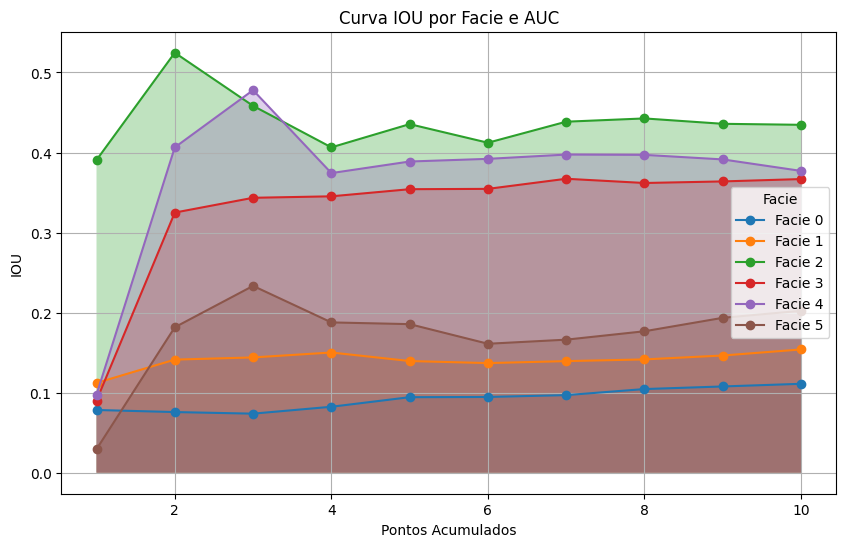

In [4]:
# Inicializar um dicionário para armazenar as AUCs por facie
auc_by_facie = {}

# Iterar sobre cada facie_id único
for facie_id in mean_iou_per_facie['facie_id'].unique():
    # Filtrar os dados para cada facie_id
    facie_data = mean_iou_per_facie[mean_iou_per_facie['facie_id'] == facie_id].sort_values(by='accumulated_point')
    
    # Calcular a AUC usando a regra dos trapézios
    auc = 0
    for i in range(1, len(facie_data)):
        x0, y0 = facie_data.iloc[i-1]['accumulated_point'], facie_data.iloc[i-1]['iou']
        x1, y1 = facie_data.iloc[i]['accumulated_point'], facie_data.iloc[i]['iou']
        auc += (x1 - x0) * (y1 + y0) / 2
    
    auc_by_facie[facie_id] = auc

# Exibir os resultados
for facie_id, auc in auc_by_facie.items():
    print(f"Facie {facie_id}: AUC = {auc}")


# Criar o gráfico
plt.figure(figsize=(10, 6))

# Iterar sobre cada facie_id único
for facie_id in mean_iou_per_facie['facie_id'].unique():
    # Filtrar os dados para cada facie_id
    facie_data = mean_iou_per_facie[mean_iou_per_facie['facie_id'] == facie_id].sort_values(by='accumulated_point')
    
    # Traçar a curva de IOU
    plt.plot(facie_data['accumulated_point'], facie_data['iou'], label=f'Facie {facie_id}', marker='o')

    # Preencher a área sob a curva para cada facie
    plt.fill_between(facie_data['accumulated_point'], facie_data['iou'], alpha=0.3)

# Adicionar rótulos e título
plt.xlabel('Pontos Acumulados')
plt.ylabel('IOU')
plt.title('Curva IOU por Facie e AUC')
plt.legend(title='Facie')

# Exibir o gráfico
plt.grid(True)
plt.show()

       sample_id  facie_id  accumulated_point       iou  num_points
0              0         0                  1  0.037065          10
1              0         0                  2  0.070886          10
2              0         0                  3  0.068481          10
3              0         0                  4  0.116163          10
4              0         0                  5  0.085572          10
...          ...       ...                ...       ...         ...
22745        399         4                  6  0.125467          10
22746        399         4                  7  0.102875          10
22747        399         4                  8  0.094097          10
22748        399         4                  9  0.079296          10
22749        399         4                 10  0.110524          10

[22750 rows x 5 columns]


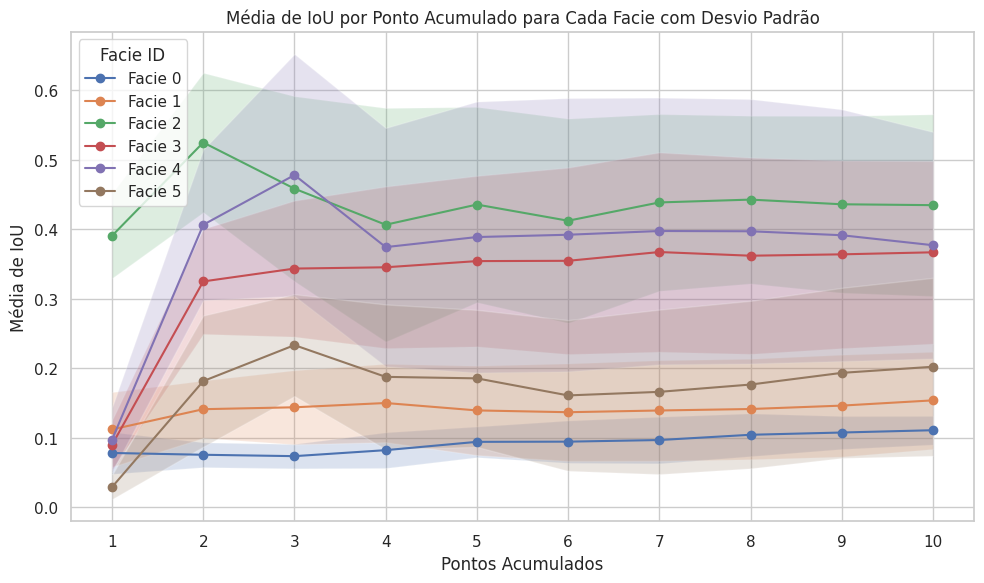

In [5]:
# Carregar os dados
results = pd.read_csv(filename)
print(results)

# Configurar estilo para o gráfico
sns.set(style="whitegrid")

# Calcular a média de IoU e o desvio padrão por facie_id e accumulated_point
mean_iou_per_facie = results.groupby(['facie_id', 'accumulated_point'])['iou'].mean().reset_index()
std_iou_per_facie = results.groupby(['facie_id', 'accumulated_point'])['iou'].std().reset_index()

# Mesclar os resultados de média e desvio padrão
merged_iou = pd.merge(mean_iou_per_facie, std_iou_per_facie, on=['facie_id', 'accumulated_point'], suffixes=('_mean', '_std'))

# Gráfico de Média de IoU: Média por Ponto Acumulado para cada Facie
plt.figure(figsize=(10, 6))

# Iterar pelas facies e plotar a média de IoU com intervalo de desvio padrão
for facie_id in merged_iou['facie_id'].unique():
    data = merged_iou[merged_iou['facie_id'] == facie_id]
    plt.plot(data['accumulated_point'], data['iou_mean'], marker='o', label=f"Facie {facie_id}")
    plt.fill_between(data['accumulated_point'], data['iou_mean'] - data['iou_std'], data['iou_mean'] + data['iou_std'], alpha=0.2)

plt.title("Média de IoU por Ponto Acumulado para Cada Facie com Desvio Padrão")
plt.xlabel("Pontos Acumulados")
plt.ylabel("Média de IoU")
plt.xticks(results['accumulated_point'].unique())  # Mostrar apenas os pontos exatos
plt.legend(title="Facie ID")
plt.tight_layout()
plt.show()